
# Introduction

Fake news, also known as misinformation, refers to false or misleading information presented as genuine news. With the rise of digital platforms and social media, the dissemination of fake news has become a significant challenge. It can have far-reaching consequences, impacting public opinion, elections, and even public health. As a result, there is a growing need for effective methods to classify and identify fake news to mitigate its harmful effects.

# Problem statement
The proliferation of fake news poses a serious threat to the integrity of information and public discourse. The challenge lies in distinguishing between legitimate news and misinformation in a vast sea of online content. Developing accurate and efficient fake news classification models is crucial to empower individuals, social media platforms, and news organizations to identify and curb the spread of false information. Addressing this problem requires innovative approaches in natural language processing, machine learning, and data analytics to build robust systems that can differentiate between trustworthy and deceptive news sources.

## Import Libraries

In [2]:
#Basic libraries
import pandas as pd
import numpy as np
import scipy as sp

#Visualization libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 5]

# Machine Learning libraries
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split

#Deep learning libraries
from tensorflow.keras.layers import Embedding, Dropout, Dense, Bidirectional, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot

#NLTK libraries
import nltk
import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#Metrics libraries
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, classification_report

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')



## Import the dataset


In [3]:
#importing the fake and true datasets
fake_news = pd.read_csv('/content/Fake.csv')
true_news = pd.read_csv('/content/True.csv')

In [4]:
# print shape of fake dataset with rows and columns
print ("The shape of the fake dataset is:"+ str(fake_news.shape))

The shape of the fake dataset is:(23481, 4)


In [5]:
fake_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [6]:
# print the shape of the true dataset with rows and columns
print ("The shape of the true dataset is:"+ str(true_news.shape))

The shape of the true dataset is:(21417, 4)


In [7]:
true_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


# Data Cleaning & Preprocessing


In [8]:
# Creating the target column for both data sets
fake_news['output']=0
true_news['output']=1

## Creating the 'news' column
* Opting for the "title" column is preferable because it holds the majority of information and is more convenient for computations.
* If we include both the "title" and "text" columns, we might achieve higher accuracy, but it comes at the cost of significantly longer execution times.
* In this scenario, I prioritize computational efficiency over accuracy by selecting the "title" column for analysis.

In [9]:
# Renaming the 'title' column and 'news'
fake_news['news']=fake_news['title']
fake_news=fake_news.drop(['title', 'text'], axis=1)

# Concatenating and dropping for true news
true_news['news']=true_news['title']
true_news=true_news.drop(['title', 'text'], axis=1)

In [10]:
# Rearranging the columns
fake_news = fake_news[['subject', 'date', 'news','output']]
true_news = true_news[['subject', 'date', 'news','output']]

## Converting the date column into datetime format
We can employ the pd.datetime function to transform our date columns into the desired date format.

In [11]:
fake_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   subject  23481 non-null  object
 1   date     23481 non-null  object
 2   news     23481 non-null  object
 3   output   23481 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 733.9+ KB


In [12]:
fake_news.head()

subject               date  \
0    News  December 31, 2017   
1    News  December 31, 2017   
2    News  December 30, 2017   
3    News  December 29, 2017   
4    News  December 25, 2017   

                                                news  output  
0   Donald Trump Sends Out Embarrassing New Year’...       0  
1   Drunk Bragging Trump Staffer Started Russian ...       0  
2   Sheriff David Clarke Becomes An Internet Joke...       0  
3   Trump Is So Obsessed He Even Has Obama’s Name...       0  
4   Pope Francis Just Called Out Donald Trump Dur...       0

In [13]:
fake_news['date'].value_counts()

May 10, 2017         46
May 26, 2016         44
May 6, 2016          44
May 5, 2016          44
May 11, 2016         43
                     ..
December 9, 2017      1
December 4, 2017      1
November 19, 2017     1
November 20, 2017     1
Jul 19, 2015          1
Name: date, Length: 1681, dtype: int64

* It's evident that the date column contains links instead of actual dates, and we must address this issue.

In [14]:
for i in list(set(fake_news['date'].value_counts().index)):
  if i[0:5] == 'https':
    print(i)
  if i[0:4] == 'HOST':
    print(i)

https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg
https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/
https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/
https://100percentfedup.com/12-yr-old-black-conservative-whose-video-to-obama-went-viral-do-you-really-love-america-receives-death-threats-from-left/
https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg


* To address this issue, let's eliminate those records from the date column to ensure a smoother conversion process.

In [15]:
#Removing links and the headline from the date column
fake_news = fake_news[~fake_news['date'].str.contains("http")]
fake_news = fake_news[~fake_news['date'].str.contains("HOST")]

In [16]:
#Converting the date to datetime format
fake_news['date'] = pd.to_datetime(fake_news['date'])
true_news['date'] = pd.to_datetime(true_news['date'])

In [17]:
## Concatinating two datasets
dataset = [fake_news, true_news]
news_dataset = pd.concat(dataset)
news_dataset

subject       date  \
0           News 2017-12-31   
1           News 2017-12-31   
2           News 2017-12-30   
3           News 2017-12-29   
4           News 2017-12-25   
...          ...        ...   
21412  worldnews 2017-08-22   
21413  worldnews 2017-08-22   
21414  worldnews 2017-08-22   
21415  worldnews 2017-08-22   
21416  worldnews 2017-08-22   

                                                    news  output  
0       Donald Trump Sends Out Embarrassing New Year’...       0  
1       Drunk Bragging Trump Staffer Started Russian ...       0  
2       Sheriff David Clarke Becomes An Internet Joke...       0  
3       Trump Is So Obsessed He Even Has Obama’s Name...       0  
4       Pope Francis Just Called Out Donald Trump Dur...       0  
...                                                  ...     ...  
21412  'Fully committed' NATO backs new U.S. approach...       1  
21413  LexisNexis withdrew two products from Chinese ...       1  
21414  Minsk cultural hub becomes haven from authorities       1  
21415  Vatican upbeat on possibility of Pope Francis ...       1  
21416  Indonesia to buy $1.14 billion worth of Russia...       1  

[44888 rows x 4 columns]

In [18]:
news_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44888 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   subject  44888 non-null  object        
 1   date     44888 non-null  datetime64[ns]
 2   news     44888 non-null  object        
 3   output   44888 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 1.7+ MB


## Text Processing
* Text processing refers to the manipulation and analysis of textual data
using various techniques and tools.
* In simpler terms, it involves working with words and sentences to extract meaningful information.
* This field plays a crucial role in natural language processing, enabling computers to understand, interpret, and generate human language.
* Text processing tasks include tasks like tokenization, where sentences are broken into individual words or phrases, and stemming, which involves reducing words to their base or root form.

In [19]:
# Creating a copy
clean_news=news_dataset.copy()

In [20]:
# News-Punctuation Cleaning
# Define a function for cleaning and preprocessing text data.
def review_cleaning(text):
    # Convert the text to lowercase to ensure uniformity.
    text = str(text).lower()
    # Remove square bracketed content, often found in textual data.
    text = re.sub('\[.*?\]', '', text)
    # Remove URLs or website links from the text.
    text = re.sub('https?://\S+|www\.\S+', '', text)
    # Remove any HTML tags that might be present in the text.
    text = re.sub('<.*?>+', '', text)
    # Remove punctuation marks from the text.
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # Remove newline characters from the text.
    text = re.sub('\n', '', text)
    # Remove alphanumeric words containing numbers.
    text = re.sub('\w*\d\w*', '', text)
    # Return the cleaned text.
    return text


In [21]:
clean_news['news']=clean_news['news'].apply(lambda x:review_cleaning(x))
clean_news.head()

subject       date                                               news  \
0    News 2017-12-31   donald trump sends out embarrassing new year’...   
1    News 2017-12-31   drunk bragging trump staffer started russian ...   
2    News 2017-12-30   sheriff david clarke becomes an internet joke...   
3    News 2017-12-29   trump is so obsessed he even has obama’s name...   
4    News 2017-12-25   pope francis just called out donald trump dur...   

   output  
0       0  
1       0  
2       0  
3       0  
4       0

## Stop words

* Stop words are common words that are often filtered out during the preprocessing of natural language text due to their high frequency and low informativeness.
* These words, such as "the," "and," "is," and "in," don't typically contribute much to the meaning of a sentence.
* Removing stop words can help reduce noise in text data and improve the efficiency of text analysis tasks.
* In the context of natural language processing and text mining, a stop words list is used to identify and exclude these common words from text data before further analysis.
* The specific set of stop words may vary depending on the application and the language being processed.
* Many programming libraries, such as NLTK (Natural Language Toolkit) in Python, provide predefined lists of stop words for various languages.
* By eliminating stop words, the focus can be shifted towards more meaningful words, enhancing the accuracy and relevance of text analysis models and algorithms.

In [22]:
# Importing the stopwords from nltk
from nltk.corpus import stopwords
# Creating a list of stopwords
nltk.download('stopwords')
stopwords_list=stopwords.words('english')
# Removing stopwords from the news column
clean_news['news']=clean_news['news'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords_list)]))
# Checking the first 5 rows
clean_news.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


subject       date                                               news  \
0    News 2017-12-31  donald trump sends embarrassing new year’s eve...   
1    News 2017-12-31  drunk bragging trump staffer started russian c...   
2    News 2017-12-30  sheriff david clarke becomes internet joke thr...   
3    News 2017-12-29  trump obsessed even obama’s name coded website...   
4    News 2017-12-25  pope francis called donald trump christmas speech   

   output  
0       0  
1       0  
2       0  
3       0  
4       0

# Data Visualization

## Count of news subject

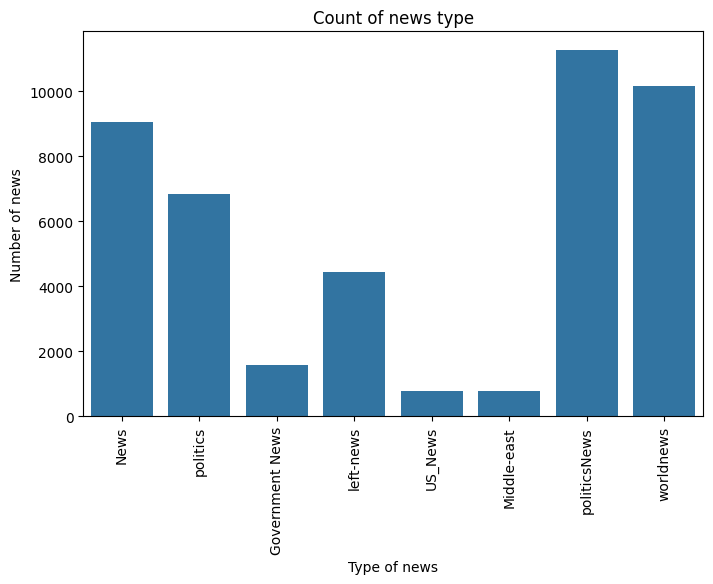

In [23]:
# Plotting the frequency plot
ax = sns.countplot(x="subject", data=clean_news)
# Setting labels and font size
ax.set(xlabel='Type of news', ylabel='Number of news', title='Count of news type')
# Invert x-axis tick labels vertically
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, va="top")
plt.show()

## Insights:
* The dataset contains a higher number of political news articles compared to any other category, with world news being the second most prevalent.
* Some class names are repeated in the dataset, indicating similar meanings, such as "news," "politics," and "government news."

## Count of news subject based on fraud column

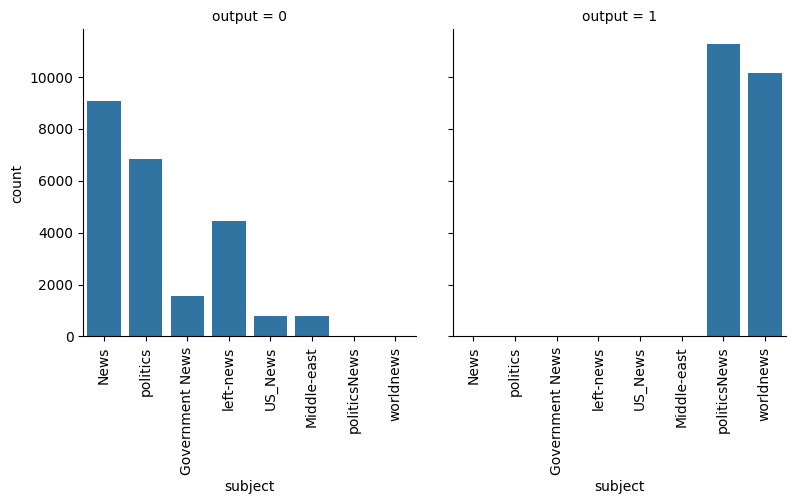

In [24]:
g = sns.catplot(x="subject", col="output", data=clean_news, kind="count", height=4, aspect=1)
#Rotating the xlabels
g.set_xticklabels(rotation=90)
plt.show()

**Insights:**
* Fake news can be found in all categories except for politics and world news.
* True news articles are only found in the politics and world news categories, and their count is high.

## Count of fake news and true news
Let's check the count of fake and true news and confirm whether our data is balanced or not

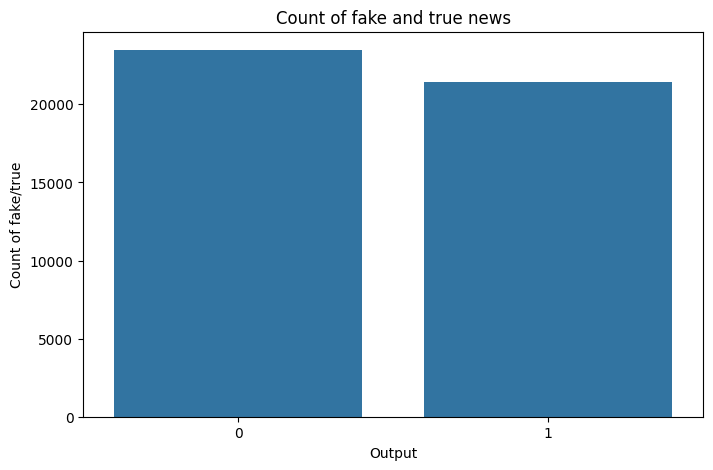

In [25]:
ax=sns.countplot(x="output", data=clean_news)
#Setting labels and font size
ax.set(xlabel='Output', ylabel='Count of fake/true', title='Count of fake and true news')
plt.show()

**Insights:**
* We have a balanced dataset.
* But the count of fake news is higher than the true news.

## Deriving new features from the news
Lets extract more features from the news feature such as
1. Polarity: The measure which signifies the sentiment of th news
2. Review length: Length of the news(number of letters and spaces)
3. Word Count: Number of words in the news

In [26]:
# #Extracting the features from the news
# clean_news['polarity'] = clean_news['news'].map(lambda text: TextBlob(text).sentiment.polarity)
# clean_news['review_len'] = clean_news['news'].astype(str).apply(len)
# clean_news['word_count'] = clean_news['news'].apply(lambda x: len(str(x).split()))

# #Plotting the distribution of the extracted feature
# plt.figure(figsize = (20, 5))
# plt.style.use('seaborn-white')
# plt.subplot(131)
# sns.distplot(clean_news['polarity'])
# fig = plt.gcf()
# plt.subplot(132)
# sns.distplot(clean_news['review_len'])
# fig = plt.gcf()
# plt.subplot(133)
# sns.distplot(clean_news['word_count'])
# fig = plt.gcf()

In [27]:
clean_news.head()

subject       date                                               news  \
0    News 2017-12-31  donald trump sends embarrassing new year’s eve...   
1    News 2017-12-31  drunk bragging trump staffer started russian c...   
2    News 2017-12-30  sheriff david clarke becomes internet joke thr...   
3    News 2017-12-29  trump obsessed even obama’s name coded website...   
4    News 2017-12-25  pope francis called donald trump christmas speech   

   output  
0       0  
1       0  
2       0  
3       0  
4       0

**Insights:**
* Most of the polarity are neutral, neither it shows some bad news nor much happy news
* The word count is between 0-1000 and the length of the news are between 0-5000 and few near 10000 words which could be an article

## N-gram analysis

### Top 20 words in News
*

In [28]:
#Function to get top n words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    print("Bag of words before sum\n", bag_of_words)
    sum_words = bag_of_words.sum(axis=0)
    print("After sum", sum_words)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    print("Words Frequnecy before sorting", words_freq)
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    print("Words Frequnecy after sorting", words_freq)
    return words_freq[:n]

In [29]:
#Calling the function for Demo
common_words_demo = get_top_n_words(clean_news['news'][:50], 20)

Bag of words before sum
   (0, 82)	1
  (0, 85)	1
  (0, 98)	1
  (0, 102)	1
  (0, 195)	1
  (0, 213)	1
  (0, 280)	1
  (0, 321)	1
  (0, 352)	1
  (1, 34)	1
  (1, 58)	1
  (1, 91)	1
  (1, 160)	1
  (1, 263)	1
  (1, 296)	1
  (1, 297)	1
  (1, 321)	1
  (2, 27)	1
  (2, 53)	1
  (2, 70)	1
  (2, 105)	1
  (2, 155)	1
  (2, 158)	1
  (2, 168)	1
  (2, 229)	1
  :	:
  (47, 101)	1
  (47, 108)	1
  (47, 125)	1
  (47, 258)	1
  (47, 305)	1
  (47, 321)	1
  (47, 344)	1
  (48, 2)	1
  (48, 20)	1
  (48, 44)	1
  (48, 95)	1
  (48, 144)	1
  (48, 220)	1
  (48, 273)	1
  (48, 285)	1
  (48, 333)	1
  (49, 153)	1
  (49, 162)	1
  (49, 166)	1
  (49, 188)	1
  (49, 198)	1
  (49, 248)	1
  (49, 274)	1
  (49, 321)	1
  (49, 332)	1
After sum [[ 2  1  2  1  1  1  1  1  2  4  1  1  1  1  2  1  1  1  1  1  1  1  1  1
   1  1  2  1  1  1  1  1  1  1  1  1  2  1  1  1  1  1  1  2  2  1  1  1
   1  1  2  2  1  1  1  1  2  1  1  3  1  1  1  1  1  1  1  1  1  1  1  1
   1  3  1  1  1  2  1  1  2  2  1  1  1  5  1  1  1  1  1  1  1  1  1  1
  

In [32]:
#Function to get top n words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    # print("Bag of words before sum\n", bag_of_words)
    sum_words = bag_of_words.sum(axis=0)
    # print("After sum", sum_words)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    # print("Words Frequnecy before sorting", words_freq)
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    # print("Words Frequnecy after sorting", words_freq)
    return words_freq[:n]
#Calling function and return only top 20 words
common_words = get_top_n_words(clean_news['news'], 20)

In [33]:
#Printing the word and frequency
for word, freq in common_words:
    print(word, freq)

#Creating the dataframe of word and frequency
df1 = pd.DataFrame(common_words, columns = ['news' , 'count'])


trump 13632
us 5095
says 3542
video 3284
obama 3123
hillary 2313
house 1989
watch 1952
new 1776
clinton 1726
white 1671
president 1580
bill 1264
russia 1135
state 1080
republican 1060
north 1031
news 999
court 979
media 920


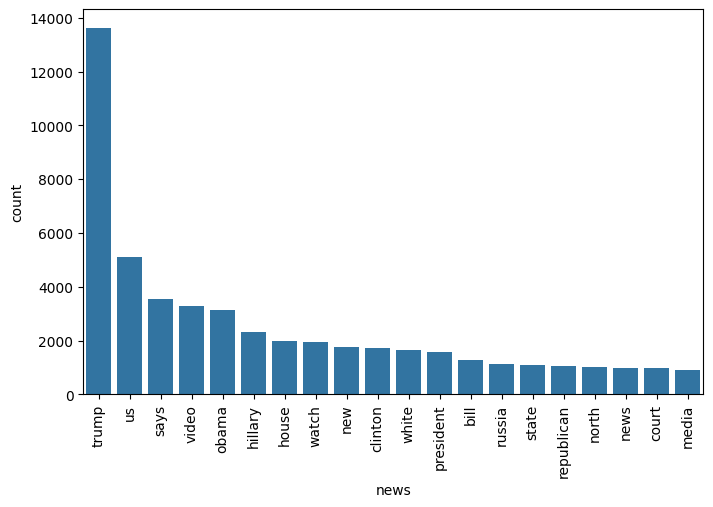

In [34]:
#Group by words and plot the sum
sns.barplot(df1.groupby('news').sum()['count'].sort_values(ascending=False))
plt.xticks(rotation = 90)
plt.show()

### Top 2 words in the news
Now let's perform it for 2 words from the news

white house 1129
donald trump 853
north korea 729
president trump 511
hillary clinton 450
trump says 408
supreme court 399
fox news 343
bernie sanders 267
islamic state 238
ted cruz 234
fake news 223
new york 212
trump supporter 208
boiler room 205
trump supporters 201
puerto rico 196
says trump 191
travel ban 189
lives matter 176


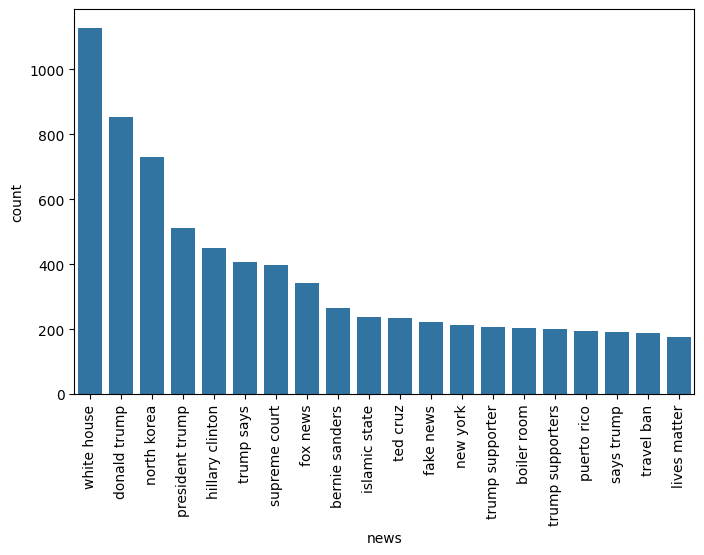

In [35]:
#Function to get top bigram words
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_n_bigram(clean_news['news'], 20)

#Printing the word and frequency
for word, freq in common_words:
    print(word, freq)

#Creating the dataframe of word and frequency
df2 = pd.DataFrame(common_words, columns = ['news' , 'count'])

#Group by words and plot the sum
sns.barplot(df2.groupby('news').sum()['count'].sort_values(ascending=False))
plt.xticks(rotation = 90)
plt.show()

black lives matter 162
boiler room ep 138
white house says 90
house speaker ryan 74
iran nuclear deal 73
factbox trump twitter 72
trump travel ban 71
new york times 69
supreme court justice 60
donald trump jr 53
trump campaign manager 50
fox news host 47
south china sea 46
highlights trump presidency 46
supreme court nominee 44
north korea sanctions 35
north korea nuclear 32
puerto rico debt 31
patrick henningsen live 30
episode sunday wire 30


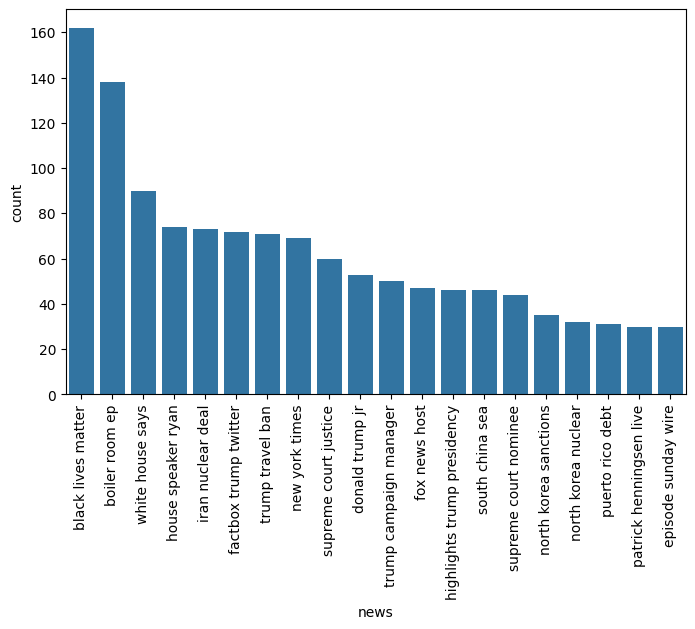

In [36]:
#Function to get top trigram words
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_n_trigram(clean_news['news'], 20)

#Printing word and their respective frequencies
for word, freq in common_words:
    print(word, freq)

#Creating a dataframe with words and count
df3 = pd.DataFrame(common_words, columns = ['news' , 'count'])

#Grouping the words and plotting their frequencies
sns.barplot(df3.groupby('news').sum()['count'].sort_values(ascending=False))
plt.xticks(rotation = 90)
plt.show()

## WordCloud of Fake and True News
Let's look at the word cloud for both fake and true news

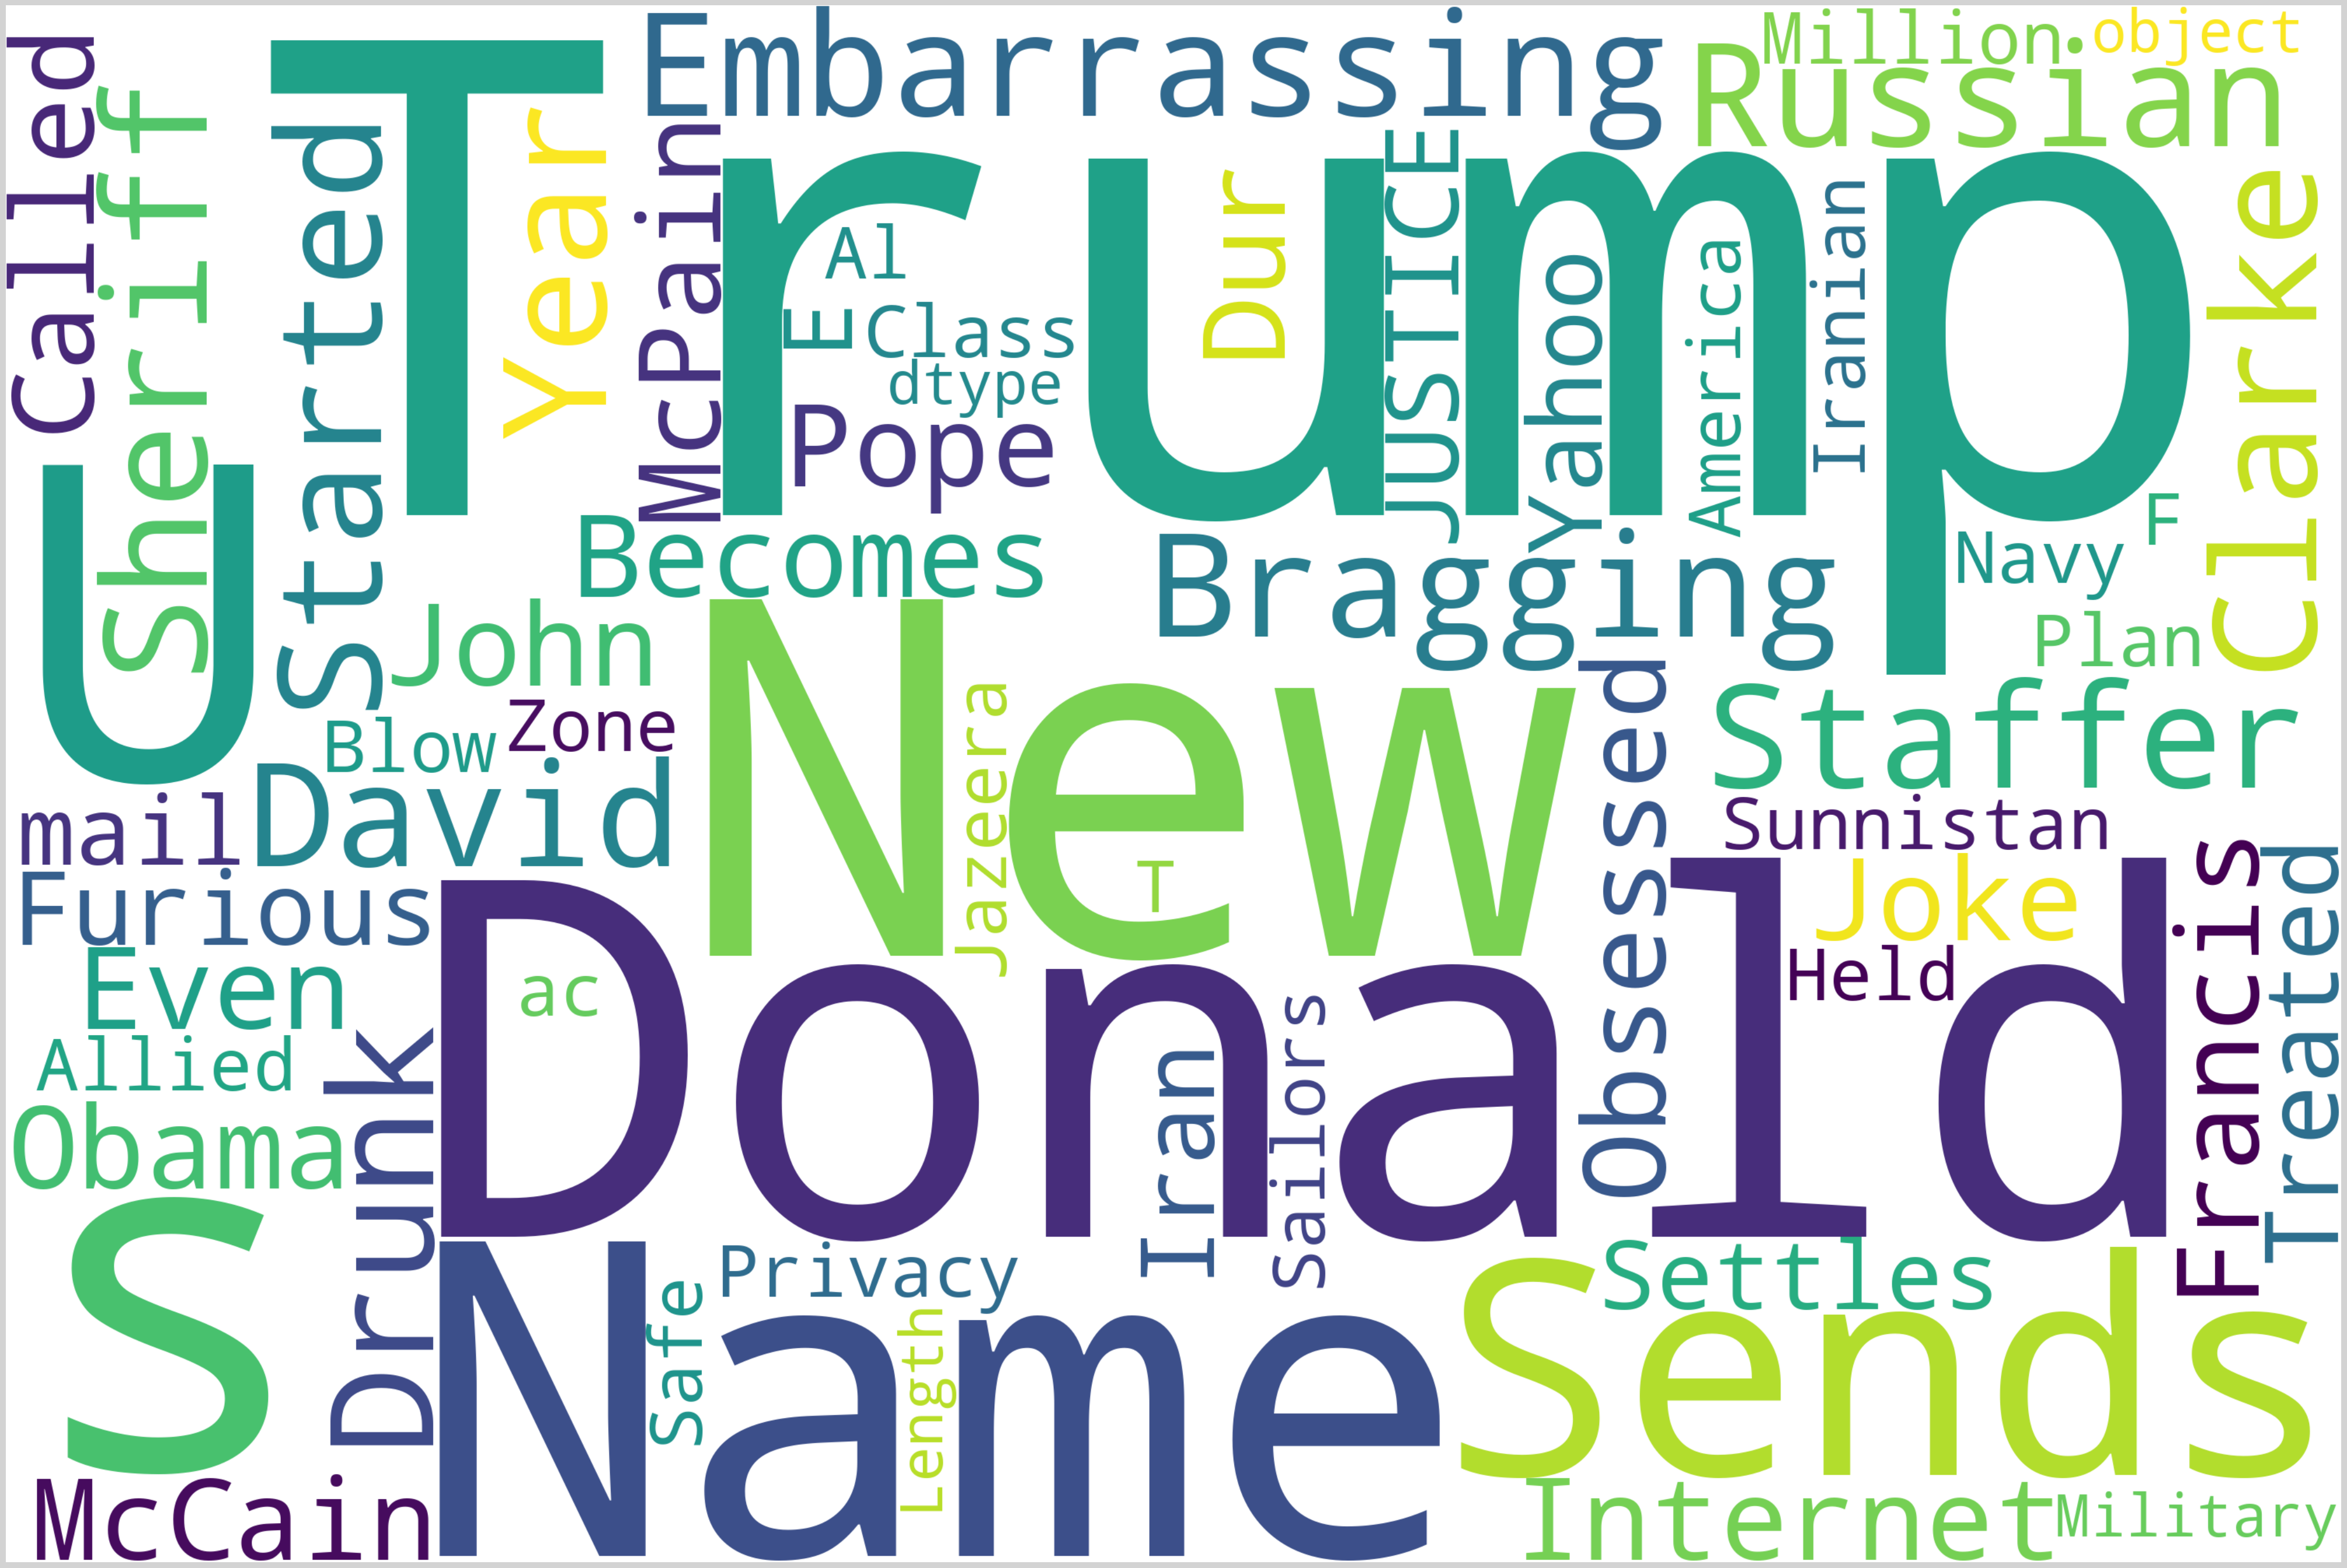

In [37]:
def generate_wordcloud(data):
    text = data["news"]
    wordcloud = WordCloud(width=3000,height=2000,background_color='white', colormap='viridis', contour_color='steelblue',stopwords=STOPWORDS).generate(str(text))
    # print(wordcloud)
    fig = plt.figure(figsize=(40, 30), facecolor='lightgray', edgecolor='darkgray')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
generate_wordcloud(fake_news)

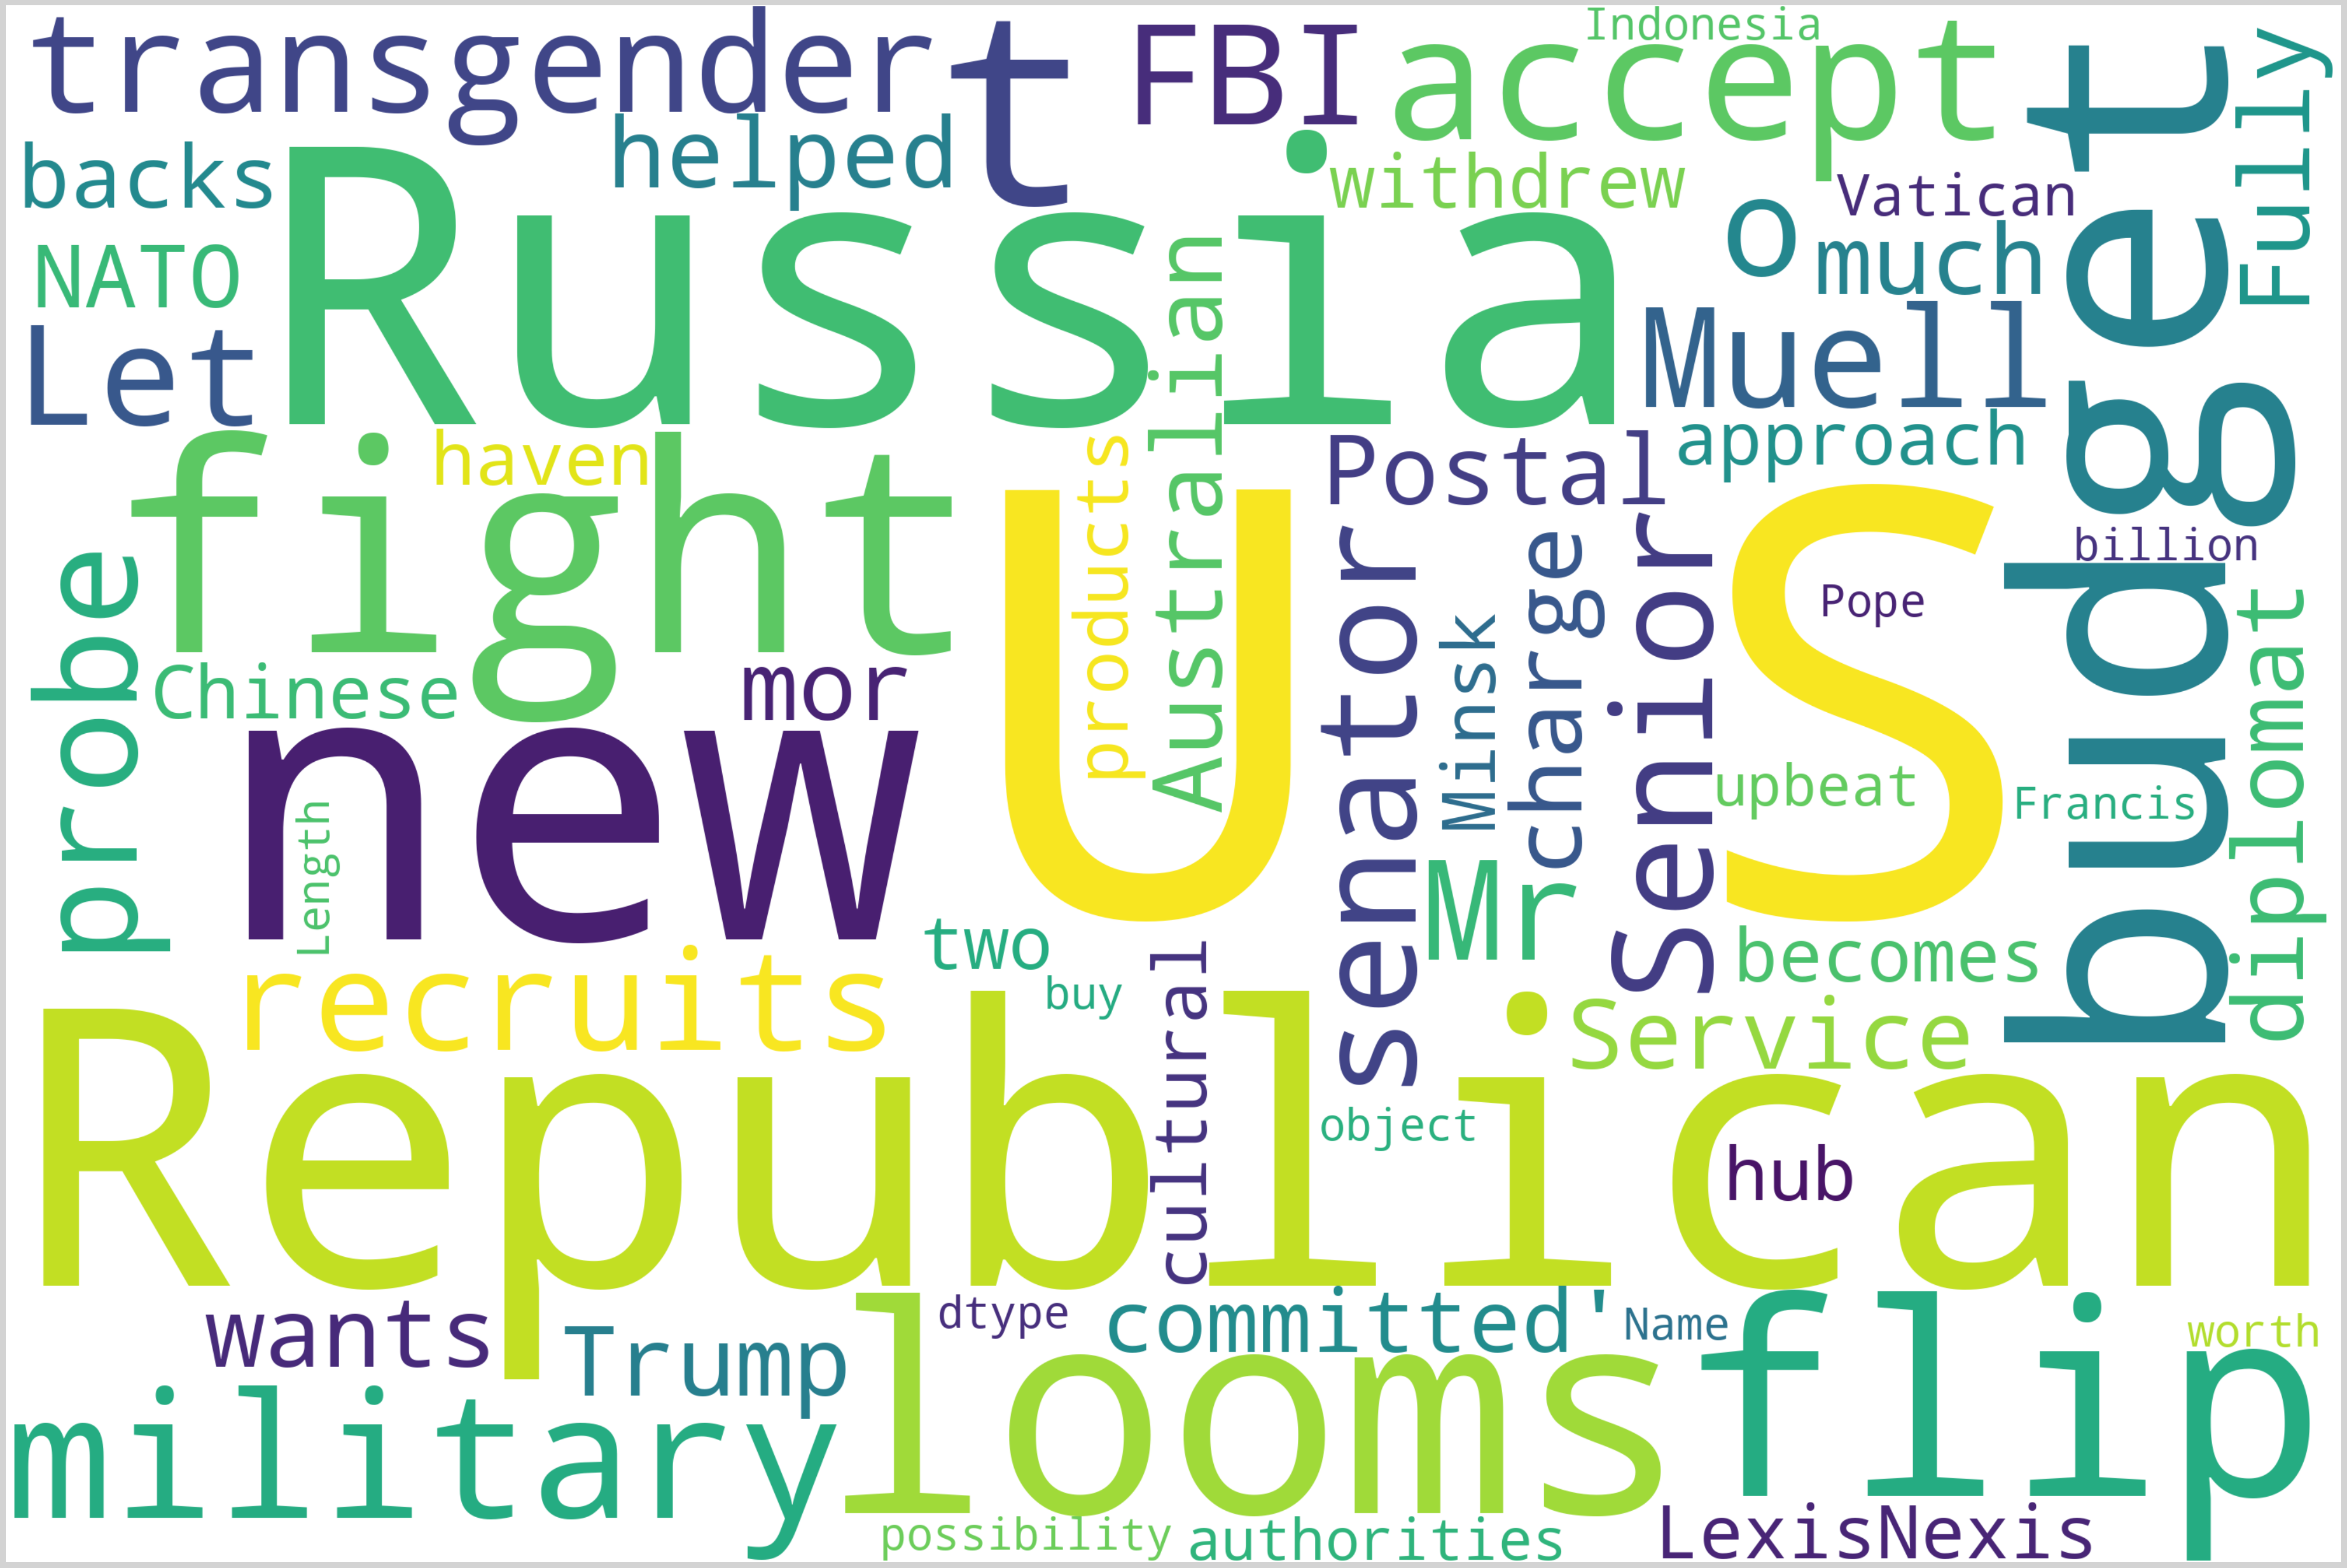

In [38]:
generate_wordcloud(true_news)

## Insights:
* Many false stories focus on Donald Trump and the United States.
* Fake news can also be found regarding topics like privacy and the internet.
* Real news tends to discuss the Republican Party and Russia more than focusing solely on Donald Trump.
* Authentic news covers subjects such as the budget and military, which fall under government-related news.

## Stemming or Lemmatization:
Stemming is a text normalization technique that aims to reduce words to their root or base form, known as the "stem." The goal is to remove suffixes from words to obtain a common base form. This process involves cutting off the ends of words, which may result in the stem not being an actual word.

<b>Example of stemming:</b>
* Original: "running"
* Stem: "run"

Common stemming algorithms include Porter Stemmer and Snowball Stemmer.

Lemmatization is also a text normalization technique, but it goes a step further compared to stemming. Instead of just removing suffixes, lemmatization transforms words to their base or dictionary form, known as the "lemma." This process ensures that the resulting form is a valid word and retains its meaning.

<b>Example of lemmatization:</b>
* Original: "running"
* Lemma: "run"

Lemmatization often requires access to a lexicon or a linguistic database to accurately map words to their base forms. It considers the context and part-of-speech of the word for more precise transformation.

In [39]:
#Extracting 'reviews' for processing
news_features=clean_news.copy()
news_features=news_features[['news']].reset_index(drop=True)
news_features.head()

news
0  donald trump sends embarrassing new year’s eve...
1  drunk bragging trump staffer started russian c...
2  sheriff david clarke becomes internet joke thr...
3  trump obsessed even obama’s name coded website...
4  pope francis called donald trump christmas speech

In [40]:
# Download NLTK data (if not already downloaded)
nltk.download('stopwords')
nltk.download('wordnet')

# Set stopwords and initialize lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# Performing lemmatization on the news dataframe
corpus = []
for i in range(0, len(news_features)):
    news = re.sub('[^a-zA-Z]', ' ', news_features['news'][i])
    news = news.lower()
    news = news.split()
    news = [lemmatizer.lemmatize(word) for word in news if not word in stop_words]
    news = ' '.join(news)
    corpus.append(news)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [41]:
corpus[:10]

['donald trump sends embarrassing new year eve message disturbing',
 'drunk bragging trump staffer started russian collusion investigation',
 'sheriff david clarke becomes internet joke threatening poke people eye',
 'trump obsessed even obama name coded website image',
 'pope francis called donald trump christmas speech',
 'racist alabama cop brutalize black boy handcuff graphic image',
 'fresh golf course trump lash fbi deputy director james comey',
 'trump said insanely racist stuff inside oval office witness back',
 'former cia director slam trump un bullying openly suggests acting like dictator tweet',
 'watch brandnew protrump ad feature much kissing make sick']

In [42]:
news_features['news']

0        donald trump sends embarrassing new year’s eve...
1        drunk bragging trump staffer started russian c...
2        sheriff david clarke becomes internet joke thr...
3        trump obsessed even obama’s name coded website...
4        pope francis called donald trump christmas speech
                               ...                        
44883    fully committed nato backs new us approach afg...
44884      lexisnexis withdrew two products chinese market
44885               minsk cultural hub becomes authorities
44886    vatican upbeat possibility pope francis visiti...
44887             indonesia buy billion worth russian jets
Name: news, Length: 44888, dtype: object

In [43]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Deep learning-LSTM
* In this part, we're leveraging a neural network to predict whether a given piece of news is fake or genuine.
* Instead of using a traditional feedforward neural network like Artificial Neural Networks (ANN), we're employing a specialized type of recurrent neural network called Long Short-Term Memory (LSTM).
* LSTM networks are designed to capture and learn dependencies over time or sequence information in data.
* They are particularly effective in handling sequence prediction tasks where maintaining long-range dependencies is crucial, such as language modeling, machine translation, speech recognition, and sentiment analysis.
* One of the key advantages of LSTM networks is their ability to address the vanishing gradient problem, which is common in traditional recurrent neural networks. This problem arises when gradients become extremely small during training, hindering the ability of the network to learn long-term dependencies.
* LSTM networks overcome this issue by incorporating specialized memory cells and gating mechanisms, allowing them to selectively retain or forget information over time.
* The architecture of an LSTM network includes three main components: input gates, forget gates, and output gates. These gates control the flow of information within the network, enabling it to process sequential data effectively.


## One hot for Embedding layers
* Before constructing any neural network layers, it's important to determine the vocabulary size.
* The vocabulary size refers to the total number of unique words present in the corpus, which is the collection of all text data.
* One reason for establishing the vocabulary size is to facilitate one-hot encoding of the sentences in the corpus for use in embedding layers.
* One-hot encoding is a technique used to represent categorical data, such as words in a sentence, as binary vectors.
* In the context of natural language processing (NLP), each word in the vocabulary is assigned a unique index, and then one-hot encoding represents each word as a binary vector where only the index corresponding to the word is set to 1, and all other indices are set to 0.
* The vocabulary size is crucial for one-hot encoding because it determines the size of the binary vectors representing the words.
* By fixing the vocabulary size to a specific value, such as 5000 in this case, we ensure that each word in the corpus is assigned an index within this range.
* Limiting the vocabulary size can help manage computational complexity and memory usage, especially when dealing with large corpora.
* However, it's essential to strike a balance between limiting the vocabulary size and ensuring that it is large enough to capture the diversity of words present in the text data.
* In summary, establishing the vocabulary size is an essential step in preparing text data for neural network models, particularly in NLP tasks where words need to be represented numerically for processing by the model.

In [44]:
words = set()
for i in range(len(corpus[:])):
  for j in corpus[i].split():
    # print(j)
    words.add(j)
print("Number of documents in the Corpus is",len(corpus))
print("Length of all the words in the Corpus is",len(words))

Number of documents in the Corpus is 44888
Length of all the words in the Corpus is 19565


In [45]:
#Setting up vocabulary size
voc_size=10000

#One hot encoding
onehot_repr=[one_hot(words,voc_size)for words in corpus]

* As we can see all the words in the sentences are transformed into their index from the vocabulary.

## Pre-padding
In neural networks, including LSTM models, it's essential for inputs to have consistent shapes and sizes to be processed effectively.
However, when dealing with text data, sentences or documents often vary in length, meaning some may be longer or shorter than others.
To ensure uniformity in input size, a process called padding is used. Padding involves adding extra tokens or characters to the input data to make all samples the same length.
In the context of text data, padding typically involves adding zeros or other placeholder tokens to the beginning or end of sentences to match the desired length.
One common approach to padding sequences of text data is to determine a maximum sequence length, often based on the longest sentence in the dataset. In this case, a common length of 5000 is chosen.
The pad_sequence() function, often provided by libraries like Keras or PyTorch, is used to perform padding on sequences. This function automatically pads sequences to a specified length, ensuring consistency in input size.
In the context of LSTM models for text processing, 'pre-padding' is often employed. Pre-padding involves adding zeros or other padding tokens to the beginning of sentences, ensuring that all sentences have the same length regardless of their original length.
By performing padding, we ensure that all input sequences fed into the LSTM model have the same length, allowing the model to process them uniformly and effectively learn patterns from the text data.

In [46]:
#Setting sentence length
sent_length=200

#Padding the sentences
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 7561 1952 3841]
 [   0    0    0 ... 3576 5527 2929]
 [   0    0    0 ...  687 5386 6427]
 ...
 [   0    0    0 ... 5157 3965 3607]
 [   0    0    0 ... 5689 4743 4154]
 [   0    0    0 ... 4510 3576 1138]]


In [47]:
embedded_docs[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

We can see all the sentences are of equal length with the addition of zeros infront of the sentences and making all the sentences of length 5000

## LSTM Model
At first we are going to develop the base model and compile it. The first layer will be the embedding layer which has the input of vocabulary size, vector features and sentence length. Later we add 30% dropout layer to prevent overfitting and the LSTM layer which has 100 neurons in the layer.In final layer we use sigmoid activation function. Later we compile the model using adam optimizer and binary cross entropy as loss function since we have only two outputs.

To understand how LSTM works please check this [link](https://colah.github.io/posts/2015-08-Understanding-LSTMs/). To give a small overview on how LSTM works,it remembers only the important sequence of words and forgets the insignificant words which doesn't add value in the prediction

In [48]:
#Creating the lstm model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100)) #Adding 100 lstm neurons in the layer
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))

#Compiling the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 40)           400000    
                                                                 
 dropout (Dropout)           (None, 200, 40)           0         
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 456501 (1.74 MB)
Trainable params: 456501 (1.74 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [50]:
y = np.array(clean_news['output'])

In [51]:
len(embedded_docs),y.shape

(44888, (44888,))

## Fitting the LSTM Model
Before fitting to the model, let's consider the padded embedded object as X and y as y itself and convert them into an array.

In [52]:
# Converting the X and y as array
X_final=np.array(embedded_docs)
y_final=np.array(y)

#Check shape of X and y final
X_final.shape,y_final.shape

((44888, 200), (44888,))

Let's split our new X and y variable into train and test and proceed with fitting the model to the data. We have considered 10 epochs and 64 as batch size. It can be varied to get better results.

In [53]:
# Train test split of the X and y final
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

# Fitting with 10 epochs and 64 batch size
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
470/470 [==============================] - 26s 46ms/step - loss: 0.4084 - accuracy: 0.8484 - val_loss: 0.1881 - val_accuracy: 0.9280
Epoch 2/10
470/470 [==============================] - 8s 18ms/step - loss: 0.1754 - accuracy: 0.9348 - val_loss: 0.1755 - val_accuracy: 0.9340
Epoch 3/10
470/470 [==============================] - 7s 14ms/step - loss: 0.1649 - accuracy: 0.9415 - val_loss: 0.1802 - val_accuracy: 0.9345
Epoch 4/10
470/470 [==============================] - 7s 15ms/step - loss: 0.1066 - accuracy: 0.9626 - val_loss: 0.1807 - val_accuracy: 0.9342
Epoch 5/10
470/470 [==============================] - 6s 13ms/step - loss: 0.0878 - accuracy: 0.9700 - val_loss: 0.2155 - val_accuracy: 0.9211
Epoch 6/10
470/470 [==============================] - 7s 15ms/step - loss: 0.0787 - accuracy: 0.9729 - val_loss: 0.2061 - val_accuracy: 0.9345
Epoch 7/10
470/470 [==============================] - 6s 13ms/step - loss: 0.0662 - accuracy: 0.9773 - val_loss: 0.2036 - val_accuracy: 0.936

## Evaluation of model
Now, let's predict the output for our test data and evaluate the predicted values with y_test

In [54]:
# Predicting from test data
y_pred=model.predict(X_test)
y_pred1 = []
for i in range(len(y_pred)):
  if float(y_pred[i]) <= 0.5:
    y_pred1.append(0)
  else:
    y_pred1.append(1)

463/463 [==============================] - 5s 7ms/step


Confusion matrix, without normalization


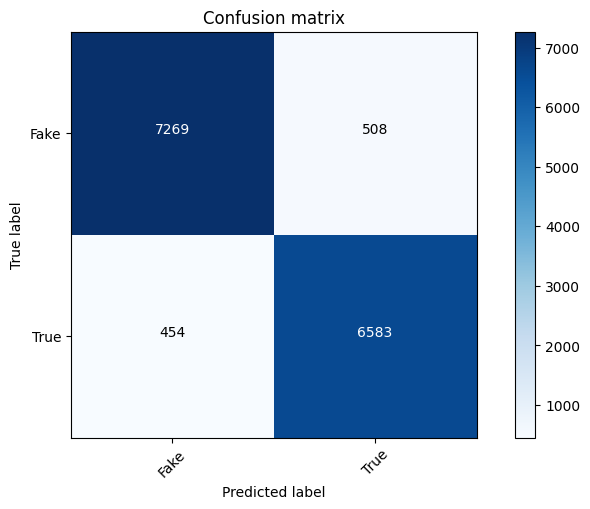

In [55]:
#Creating confusion matrix
#confusion_matrix(y_test,y_pred)
cm = metrics.confusion_matrix(y_test, y_pred1)
plot_confusion_matrix(cm,classes=['Fake','True'])

In [56]:
#Checking for accuracy
accuracy_score(y_test,y_pred1)

0.9350614283785608

We have got an accuracy of 93%. That's awesome !

In [57]:
# Creating classification report
print(classification_report(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      7777
           1       0.93      0.94      0.93      7037

    accuracy                           0.94     14814
   macro avg       0.93      0.94      0.93     14814
weighted avg       0.94      0.94      0.94     14814



From the classification report we can see the accuracy value is nearly around 93%. We have to concentrate on precision score and it is 93% which is great.

## Bidirectional LSTM

* Bi-LSTM is an extension of normal LSTM with two independent RNN's together.
* The normal LSTM is uni directional where it cannot know the future words whereas in Bi-LSTM we can predict the future use of words as there is a backward information passed on from the other RNN layer in reverse.
* There is only one change made in the code compared to the LSTM, here we use Bidirectional() function and call LSTM inside.

In [58]:
# Creating bidirectional lstm model
embedding_vector_features=40
model1=Sequential()
model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model1.add(Bidirectional(LSTM(100))) # Bidirectional LSTM layer
model1.add(Dropout(0.3))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 40)           400000    
                                                                 
 bidirectional (Bidirection  (None, 200)               112800    
 al)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 513001 (1.96 MB)
Trainable params: 513001 (1.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## Fit and Evaluation of Model


In [59]:
# Fitting the model
model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
470/470 [==============================] - 29s 54ms/step - loss: 0.2983 - accuracy: 0.8723 - val_loss: 0.1720 - val_accuracy: 0.9313
Epoch 2/10
470/470 [==============================] - 12s 26ms/step - loss: 0.1278 - accuracy: 0.9511 - val_loss: 0.1570 - val_accuracy: 0.9394
Epoch 3/10
470/470 [==============================] - 11s 22ms/step - loss: 0.0894 - accuracy: 0.9677 - val_loss: 0.1617 - val_accuracy: 0.9414
Epoch 4/10
470/470 [==============================] - 11s 22ms/step - loss: 0.0661 - accuracy: 0.9782 - val_loss: 0.1732 - val_accuracy: 0.9412
Epoch 5/10
470/470 [==============================] - 10s 22ms/step - loss: 0.0458 - accuracy: 0.9853 - val_loss: 0.2087 - val_accuracy: 0.9372
Epoch 6/10
470/470 [==============================] - 10s 20ms/step - loss: 0.0326 - accuracy: 0.9902 - val_loss: 0.2504 - val_accuracy: 0.9365
Epoch 7/10
470/470 [==============================] - 10s 22ms/step - loss: 0.0251 - accuracy: 0.9923 - val_loss: 0.2561 - val_accuracy:

463/463 [==============================] - 4s 7ms/step
Confusion matrix, without normalization


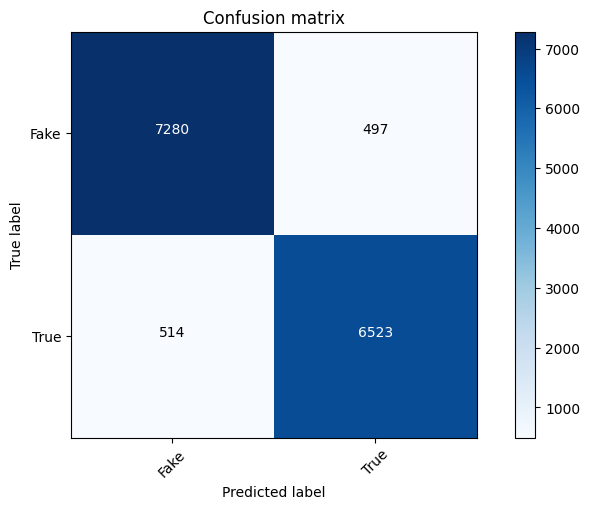

In [60]:
# Predicting from test data
y_pred2=model1.predict(X_test)
y_pred3 = []
for i in range(len(y_pred2)):
  if float(y_pred2[i]) <= 0.5:
    y_pred3.append(0)
  else:
    y_pred3.append(1)
#Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred3)
plot_confusion_matrix(cm,classes=['Fake','True'])

In [61]:
#Calculating Accuracy score
accuracy_score(y_test,y_pred3)

0.9317537464560551

In [62]:
# Creating classification report
print(classification_report(y_test,y_pred3))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      7777
           1       0.93      0.93      0.93      7037

    accuracy                           0.93     14814
   macro avg       0.93      0.93      0.93     14814
weighted avg       0.93      0.93      0.93     14814

